In [2]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.7 MB/s eta 0:00:00a 0:00:01


/tmp/ipykernel_37/1024234074.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float)


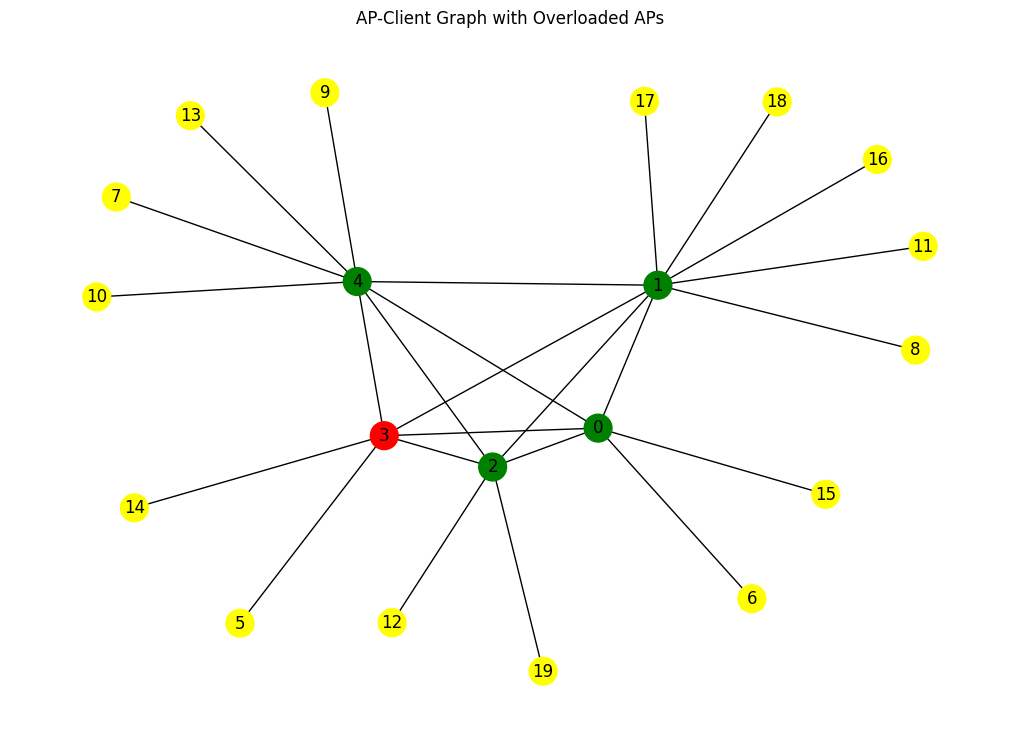

In [92]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

num_nodes = 20
num_aps = 5
num_clients = num_nodes - num_aps

# Randomly assign APs and clients
ap_indices = np.arange(num_aps)
client_indices = np.arange(num_aps, num_nodes)

# Node features: [queue_len, load, utilization, signal_strength]

features = []
for i in range(num_nodes):
    if i in ap_indices:
        # Random features for APs
        queue_len = np.random.randint(1, 50)
        load = np.random.uniform(0.2, 1.0)
        utilization = np.random.uniform(0.2, 1.0)
        signal_strength = np.random.uniform(-45, -35)
    else:
        # Random features for clients
        queue_len = np.random.randint(1, 5)
        load = np.random.uniform(0.05, 0.3)
        utilization = np.random.uniform(0.05, 0.3)
        signal_strength = np.random.uniform(-70, -50)
    features.append([queue_len, load, utilization, signal_strength])

features = torch.tensor(features, dtype=torch.float)

labels = []
for i in range(num_nodes):
    if i in ap_indices:
        queue_len = features[i][0].item()
        load = features[i][1].item()
        utilization = features[i][2].item()
        # Set an overload condition (tweak as you wish)
        if queue_len > 30 and load > 0.7 and utilization > 0.7:
            labels.append(2)  # Overloaded AP
        else:
            labels.append(0)  # Normal AP
    else:
        labels.append(1)      # Client


features = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

# Edges: connect each client to a random AP, and APs to each other
edge_index = []
edge_attr = []
for client in client_indices:
    ap = np.random.choice(ap_indices)
    edge_index.append([ap, client])
    edge_index.append([client, ap])
    # Edge features: [link_quality, distance, interference]
    edge_attr.append([np.random.uniform(0.5, 1.0), np.random.uniform(5, 20), np.random.uniform(0.1, 0.5)])
    edge_attr.append([np.random.uniform(0.5, 1.0), np.random.uniform(5, 20), np.random.uniform(0.1, 0.5)])

# Connect APs to each other (resource constraints)
for i in ap_indices:
    for j in ap_indices:
        if i != j:
            edge_index.append([i, j])
            edge_attr.append([np.random.uniform(0.3, 0.7), np.random.uniform(10, 30), np.random.uniform(0.2, 0.6)])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

feature_names = ['queue_len', 'load', 'utilization', 'signal_strength']
edge_feature_names = ['link_quality', 'distance', 'interference']

G = Data(x=features, edge_index=edge_index, edge_attr=edge_attr, y=y)

# Visualization
G_nx = to_networkx(G, node_attrs=['y'], to_undirected=True)

color_map = []
for node in G_nx.nodes():
    label = G.y[node].item()  # Get the label for each node
    if label == 2:  # Overloaded AP
        color_map.append('red')
    elif label == 0:  # Normal AP
        color_map.append('green')
    elif label == 1:  # Client
        color_map.append('yellow')
    else:
        color_map.append('gray')

plt.figure(figsize=(10, 7))
nx.draw(G_nx, with_labels=True, node_color=color_map, node_size=400, font_color='black')
plt.title("AP-Client Graph with Overloaded APs")
plt.show()


In [93]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNN(torch.nn.Module):
    def __init__ (self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

in_channels = G.x.shape[1]
hidden_channels = 16
out_channels = 3  # e.g., 0: normal AP, 1: overloaded AP, 2: client

model = GNN(in_channels, hidden_channels, out_channels)

num_nodes = G.x.shape[0]
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[:int(0.6*num_nodes)] = True
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[int(0.6*num_nodes):int(0.8*num_nodes)] = True
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[int(0.8*num_nodes):] = True

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(G.x, G.edge_index)
    loss = F.nll_loss(out[train_mask], G.y[train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

@torch.no_grad()
def test(mask):
    model.eval()
    out = model(G.x, G.edge_index)
    pred = out.argmax(dim=1)
    correct = pred[mask].eq(G.y[mask]).sum().item()
    acc = correct / mask.sum().item()
    return acc
print("G.x shape:", G.x.shape)
print("G.y shape:", G.y.shape)
print("train_mask shape:", train_mask.shape)
print("Model output shape:", model(G.x, G.edge_index).shape)

for epoch in range(1, 501):
    loss = train()
    train_acc = test(train_mask)
    val_acc = test(val_mask)
    test_acc = test(test_mask)
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}')

G.x shape: torch.Size([20, 4])
G.y shape: torch.Size([20])
train_mask shape: torch.Size([20])
Model output shape: torch.Size([20, 3])
Epoch: 020, Loss: 2.4179, Train Acc: 0.3333, Val Acc: 0.2500, Test Acc: 0.0000
Epoch: 040, Loss: 1.5907, Train Acc: 0.4167, Val Acc: 0.2500, Test Acc: 0.0000
Epoch: 060, Loss: 0.9126, Train Acc: 0.4167, Val Acc: 0.7500, Test Acc: 0.2500
Epoch: 080, Loss: 0.7961, Train Acc: 0.3333, Val Acc: 0.7500, Test Acc: 0.2500
Epoch: 100, Loss: 0.7458, Train Acc: 0.4167, Val Acc: 0.7500, Test Acc: 0.2500
Epoch: 120, Loss: 0.7051, Train Acc: 0.7500, Val Acc: 0.7500, Test Acc: 0.5000
Epoch: 140, Loss: 0.6692, Train Acc: 0.9167, Val Acc: 0.7500, Test Acc: 0.7500
Epoch: 160, Loss: 0.6377, Train Acc: 0.9167, Val Acc: 0.7500, Test Acc: 1.0000
Epoch: 180, Loss: 0.6097, Train Acc: 0.9167, Val Acc: 0.7500, Test Acc: 1.0000
Epoch: 200, Loss: 0.5817, Train Acc: 0.9167, Val Acc: 0.7500, Test Acc: 1.0000
Epoch: 220, Loss: 0.5570, Train Acc: 0.9167, Val Acc: 0.7500, Test Acc: 1.00

In [132]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

num_nodes = 20
num_aps = 5
num_clients = num_nodes - num_aps

ap_indices = np.arange(num_aps)
client_indices = np.arange(num_aps, num_nodes)

# Node features: [queue_len, load, utilization, signal_strength]

features = []
for i in range(num_nodes):
    if i in ap_indices:
        # Random features for APs
        queue_len = np.random.randint(1, 50)
        load = np.random.uniform(0.2, 1.0)
        utilization = np.random.uniform(0.2, 1.0)
        signal_strength = np.random.uniform(-45, -35)
    else:
        # Random features for clients
        queue_len = np.random.randint(1, 5)
        load = np.random.uniform(0.05, 0.3)
        utilization = np.random.uniform(0.05, 0.3)
        signal_strength = np.random.uniform(-70, -50)
    features.append([queue_len, load, utilization, signal_strength])

features = torch.tensor(features, dtype=torch.float)

labels = []
for i in range(num_nodes):
    if i in ap_indices:
        queue_len = features[i][0].item()
        load = features[i][1].item()
        utilization = features[i][2].item()
        # Set an overload condition (tweak as you wish)
        if queue_len > 30 and load > 0.7 and utilization > 0.7:
            labels.append(2)  # Overloaded AP
        else:
            labels.append(0)  # Normal AP
    else:
        labels.append(1)      # Client


features = torch.tensor(features, dtype=torch.float)
y = torch.tensor(labels, dtype=torch.long)

# Edges: connect each client to a random AP, and APs to each other
edge_index = []
edge_attr = []
for client in client_indices:
    ap = np.random.choice(ap_indices)
    edge_index.append([ap, client])
    edge_index.append([client, ap])
    edge_attr.append([np.random.uniform(0.5, 1.0), np.random.uniform(5, 20), np.random.uniform(0.1, 0.5)])
    edge_attr.append([np.random.uniform(0.5, 1.0), np.random.uniform(5, 20), np.random.uniform(0.1, 0.5)])

for i in ap_indices:
    for j in ap_indices:
        if i != j:
            edge_index.append([i, j])
            edge_attr.append([np.random.uniform(0.3, 0.7), np.random.uniform(10, 30), np.random.uniform(0.2, 0.6)])

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)

new_graph1 = Data(x=features, edge_index=edge_index, edge_attr=edge_attr, y=y)

# Visualization
G_nx_1 = to_networkx(new_graph1, node_attrs=['y'], to_undirected=True)

features_req = features


/tmp/ipykernel_37/616053816.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float)


In [133]:
# Assume 'model' is your trained GNN and 'new_graph' is a PyG Data object
model.eval()
with torch.no_grad():
    out = model(new_graph1.x, new_graph1.edge_index)
    pred = out.argmax(dim=1)  # Predicted class for each node

print("Predicted node classes:", pred)


Predicted node classes: tensor([0, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])


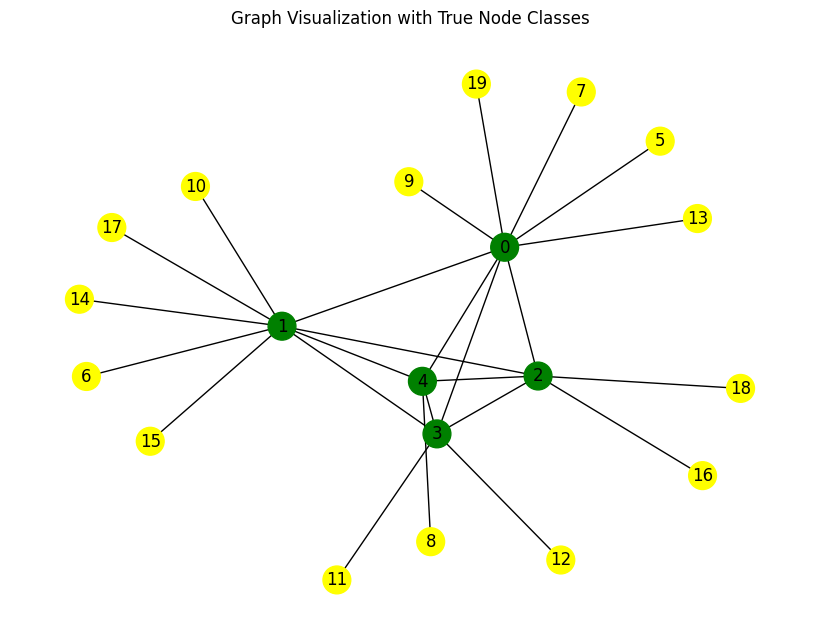

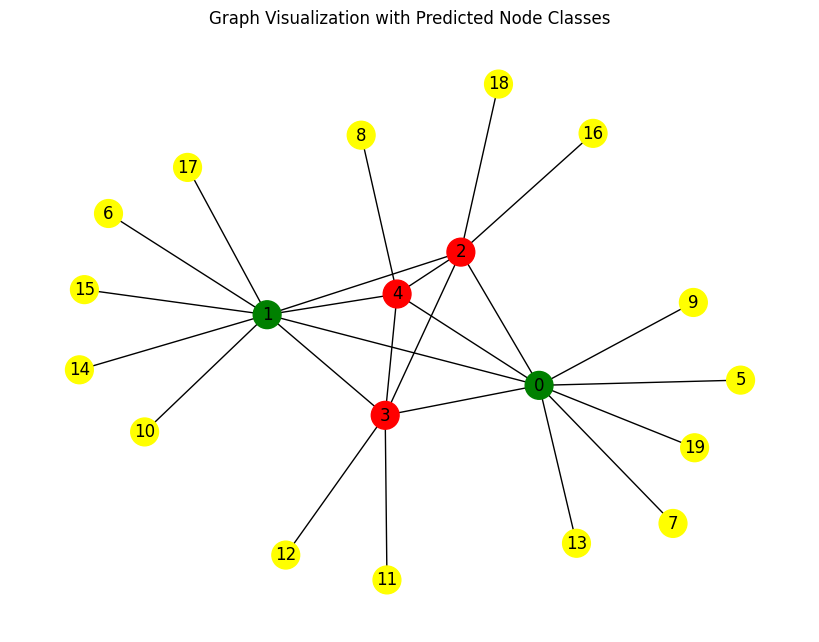

In [134]:
# For true labels
true_color_map = []
for node in G_nx_1.nodes():
    label = new_graph1.y[node].item()
    if label == 0:
        true_color_map.append('green')
    elif label == 1:
        true_color_map.append('yellow')
    elif label == 2:
        true_color_map.append('red')
    else:
        true_color_map.append('gray')

plt.figure(figsize=(8, 6))
nx.draw(G_nx_1, with_labels=True, node_color=true_color_map, node_size=400, font_color='black')
plt.title("Graph Visualization with True Node Classes")
plt.show()

# For predicted labels
pred_color_map = []
for node in G_nx_1.nodes():
    label = pred[node].item()
    if label == 0:
        pred_color_map.append('green')
    elif label == 1:
        pred_color_map.append('yellow')
    elif label == 2:
        pred_color_map.append('red')
    else:
        pred_color_map.append('gray')

plt.figure(figsize=(8, 6))
nx.draw(G_nx_1, with_labels=True, node_color=pred_color_map, node_size=400, font_color='black')
plt.title("Graph Visualization with Predicted Node Classes")
plt.show()

In [ ]:
#false positives don't hurt! (model will get better on using GAT mechanisms and more extensive training dataset)

In [106]:
#inspecting graph

In [107]:
feature_names = ['queue_len', 'load', 'utilization', 'signal_strength']
for i in range(G.num_nodes):
    features = {name: G.x[i][j].item() for j, name in enumerate(feature_names)}
    print(f"Node {i}: {features}")


Node 0: {'queue_len': 19.0, 'load': 0.9685579538345337, 'utilization': 0.3721049427986145, 'signal_strength': -37.97209167480469}
Node 1: {'queue_len': 12.0, 'load': 0.4456353187561035, 'utilization': 0.6259180903434753, 'signal_strength': -44.00596237182617}
Node 2: {'queue_len': 13.0, 'load': 0.8498006463050842, 'utilization': 0.4648693799972534, 'signal_strength': -40.01771545410156}
Node 3: {'queue_len': 42.0, 'load': 0.9242275953292847, 'utilization': 0.8025956153869629, 'signal_strength': -42.23726272583008}
Node 4: {'queue_len': 20.0, 'load': 0.7399176955223083, 'utilization': 0.21393509209156036, 'signal_strength': -44.550357818603516}
Node 5: {'queue_len': 3.0, 'load': 0.16020652651786804, 'utilization': 0.20887064933776855, 'signal_strength': -68.14603424072266}
Node 6: {'queue_len': 1.0, 'load': 0.2295176386833191, 'utilization': 0.155774787068367, 'signal_strength': -68.38477325439453}
Node 7: {'queue_len': 2.0, 'load': 0.20969267189502716, 'utilization': 0.0864177122712135

In [108]:
print("\nEdge Features:")
edge_feature_names = ['link_quality', 'distance', 'interference']
for e in range(G.num_edges):
    src, dst = G.edge_index[:, e].tolist()
    features = {name: G.edge_attr[e][j].item() for j, name in enumerate(edge_feature_names)}
    print(f"Edge {src} -> {dst}: {features}")



Edge Features:
Edge 3 -> 5: {'link_quality': 0.5246204137802124, 'distance': 8.783773422241211, 'interference': 0.37227702140808105}
Edge 5 -> 3: {'link_quality': 0.6580594182014465, 'distance': 17.46005630493164, 'interference': 0.45200037956237793}
Edge 0 -> 6: {'link_quality': 0.9061962366104126, 'distance': 14.680866241455078, 'interference': 0.3267726004123688}
Edge 6 -> 0: {'link_quality': 0.5342045426368713, 'distance': 12.612309455871582, 'interference': 0.32534071803092957}
Edge 4 -> 7: {'link_quality': 0.7929447293281555, 'distance': 15.660710334777832, 'interference': 0.20476475358009338}
Edge 7 -> 4: {'link_quality': 0.926500678062439, 'distance': 14.192068099975586, 'interference': 0.4106392562389374}
Edge 1 -> 8: {'link_quality': 0.7855590581893921, 'distance': 9.794651985168457, 'interference': 0.21338456869125366}
Edge 8 -> 1: {'link_quality': 0.6407012343406677, 'distance': 16.11946678161621, 'interference': 0.3384607136249542}
Edge 4 -> 9: {'link_quality': 0.59235835

In [135]:
features_req

tensor([[ 1.8000e+01,  5.7399e-01,  7.7497e-01, -4.0928e+01],
        [ 1.7000e+01,  3.3911e-01,  8.5020e-01, -3.7631e+01],
        [ 2.8000e+01,  6.5677e-01,  9.9261e-01, -3.5371e+01],
        [ 3.0000e+01,  7.4319e-01,  8.0543e-01, -4.3453e+01],
        [ 3.3000e+01,  2.6665e-01,  8.2028e-01, -3.5410e+01],
        [ 4.0000e+00,  2.9613e-01,  1.3174e-01, -6.0113e+01],
        [ 1.0000e+00,  1.8989e-01,  2.5344e-01, -6.5588e+01],
        [ 1.0000e+00,  9.1959e-02,  2.4488e-01, -6.1678e+01],
        [ 4.0000e+00,  5.4080e-02,  8.2627e-02, -5.0340e+01],
        [ 1.0000e+00,  1.6332e-01,  1.2359e-01, -6.0406e+01],
        [ 2.0000e+00,  1.5794e-01,  1.9565e-01, -6.7616e+01],
        [ 4.0000e+00,  6.9125e-02,  7.5751e-02, -5.3587e+01],
        [ 3.0000e+00,  1.6490e-01,  9.7076e-02, -5.4961e+01],
        [ 3.0000e+00,  2.8963e-01,  5.2794e-02, -5.0809e+01],
        [ 3.0000e+00,  2.7176e-01,  2.7205e-01, -5.0547e+01],
        [ 3.0000e+00,  5.3916e-02,  2.1758e-01, -5.6315e+01],
        

In [ ]:
import torch
import numpy as np

class WirelessEnv:
    def __init__(self, features, ap_indices, client_indices, overload_thresh=0.8, max_overloaded_aps=1):
        self.features = features.clone()
        self.num_nodes = features.shape[0]
        self.ap_indices = ap_indices
        self.client_indices = client_indices
        self.overload_thresh = overload_thresh
        self.max_overloaded_aps = max_overloaded_aps
        self.done = False

    def reset(self):
        self.state = self.features.clone()
        self.done = False
        return self._get_obs()

    def _get_obs(self):
        return self.state.flatten().numpy()  # flatten for policy input

    def step(self, actions):
        """
        Action space: for each client, assign to AP (actions is an array of ap_indices per client)
        """
        # apply action
        associ_matrix = np.zeros((len(self.client_indices), len(self.ap_indices)))
        for i, ap in enumerate(actions):
            associ_matrix[i, ap] = 1

        # aggregate AP loads/utilizations based on current assignment 
        ap_loads = np.zeros(len(self.ap_indices))
        for i, ap in enumerate(actions):
            ap_loads[ap] += self.state[self.client_indices[i], 1]  # load of each client

        # update AP utilization features for simulation
        for i, ap_i in enumerate(self.ap_indices):
            self.state[ap_i, 2] = min(1., ap_loads[i])  # utilization capped at 1

        # calculate reward/constraint
        num_overloaded = 0
        for ap_i in self.ap_indices:
            utilization = self.state[ap_i, 2].item()
            if utilization > self.overload_thresh:
                num_overloaded += 1
        reward = -num_overloaded  # penalize overload directly
        constraint_cost = int(num_overloaded > self.max_overloaded_aps)

        # simulate done at end of episode (one action per client per round)
        self.done = True
        obs = self._get_obs()
        return obs, reward, constraint_cost, self.done


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class PolicyNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)  # logits for each possible AP for each client
# 1d vector of length num_clients * num_aps

In [145]:
class RCPOAgent:
    def __init__(self, policy, lr=1e-3, lambda_init=1.0):
        self.policy = policy
        self.optimizer = torch.optim.Adam(policy.parameters(), lr=lr)
        self.lambda_constr = lambda_init

    def select_action(self, state, num_clients, num_aps):
        # State flatten, forward
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        logits = self.policy(state)
        # for each client, pick AP (softmax gives probability for each AP)
        actions = torch.multinomial(F.softmax(logits.view(num_clients, num_aps), dim=1), 1).squeeze(1).cpu().numpy()
        return actions

    def update(self, states, actions, rewards, constraint_costs):
        # Policy gradient w/ RCPO
        states = torch.tensor(np.array(states), dtype=torch.float)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float)
        constraint_costs = torch.tensor(constraint_costs, dtype=torch.float)
        logits = self.policy(states)
        logits = logits.view(states.shape[0], -1, len(set(actions[0])))  # [batch, num_clients, num_aps]
        # get log-probs for selected actions
        logprobs = []
        for b in range(states.shape[0]):
            probs = F.softmax(logits[b], dim=1)
            probs = probs.t()
            print("probs.shape:", probs.shape)
            print("actions[b]:", actions[b])
            print("max(actions[b]):", actions[b].max())
            print("num_aps:", num_aps)
            log_probs_ap = torch.log(probs[range(len(actions[b])), actions[b]])
            logprobs.append(log_probs_ap.sum())  # sum across clients
        logprobs = torch.stack(logprobs)
        # RCPO objective
        loss = -(rewards - self.lambda_constr * constraint_costs) * logprobs
        loss = loss.mean()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        # Lambda update
        avg_constraint = constraint_costs.mean().item()
        allowed_constraint = 0
        lr_lambda = 0.05
        self.lambda_constr += lr_lambda * (avg_constraint - allowed_constraint)
        self.lambda_constr = max(0, self.lambda_constr)  # ensure non-negative



In [150]:
features = features_req
ap_indices = np.arange(5)
client_indices = np.arange(5, 20)
env = WirelessEnv(features, ap_indices, client_indices)

policy = PolicyNet(input_dim=features.numel(), output_dim=len(client_indices)*len(ap_indices))
agent = RCPOAgent(policy)

num_episodes = 15
for ep in range(num_episodes):
    state = env.reset()
    done = False
    states, actions, rewards, constraint_costs = [], [], [], []
    while not done:
        action = agent.select_action(state, len(client_indices), len(ap_indices))
        next_state, reward, constraint_cost, done = env.step(action)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        constraint_costs.append(constraint_cost)
        state = next_state
    agent.update(states, actions, rewards, constraint_costs)
    print(f"Episode {ep}: reward={sum(rewards):.2f}, constraint_violation={sum(constraint_costs):.2f}, lambda={agent.lambda_constr:.2f}")


probs.shape: torch.Size([15, 5])
actions[b]: tensor([2, 1, 0, 0, 1, 4, 0, 0, 0, 4, 3, 2, 4, 0, 3])
max(actions[b]): tensor(4)
num_aps: 5
Episode 0: reward=0.00, constraint_violation=0.00, lambda=1.00
probs.shape: torch.Size([15, 5])
actions[b]: tensor([4, 1, 0, 3, 1, 4, 0, 0, 0, 4, 3, 2, 4, 1, 3])
max(actions[b]): tensor(4)
num_aps: 5
Episode 1: reward=-1.00, constraint_violation=0.00, lambda=1.00
probs.shape: torch.Size([15, 5])
actions[b]: tensor([2, 1, 0, 0, 2, 4, 4, 0, 4, 4, 3, 2, 2, 2, 3])
max(actions[b]): tensor(4)
num_aps: 5
Episode 2: reward=-1.00, constraint_violation=0.00, lambda=1.00
probs.shape: torch.Size([15, 5])
actions[b]: tensor([2, 1, 0, 0, 1, 4, 4, 0, 0, 4, 0, 2, 2, 0, 3])
max(actions[b]): tensor(4)
num_aps: 5
Episode 3: reward=0.00, constraint_violation=0.00, lambda=1.00
probs.shape: torch.Size([15, 5])
actions[b]: tensor([2, 1, 0, 0, 2, 4, 4, 0, 4, 4, 3, 2, 2, 0, 3])
max(actions[b]): tensor(4)
num_aps: 5
Episode 4: reward=-1.00, constraint_violation=0.00, lambda=1.

due to small network for demonstration, extremely fast convergence and flat reward landscape/ limited action space-> lesser improvement but constraints satisfied ✅, reward=0 implies finally no AP is overloaded ✅.